### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os, sys, shutil, importlib, glob

In [2]:
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object

/opt/conda/lib/python3.8/site-packages/celloracle/trajectory/markov_simulation.py:17: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_walk" failed type inference due to: Undecided type $22load_method.7 := <undecided>
During: resolving caller type: $22load_method.7
During: typing of call at /opt/conda/lib/python3.8/site-packages/celloracle/trajectory/markov_simulation.py (40)


File "../../../../opt/conda/lib/python3.8/site-packages/celloracle/trajectory/markov_simulation.py", line 40:
def _walk(start_cell_id_array, transition_prob, n_steps):
    <source elided>

    li.append(list(ids_now))
    ^

  @jit(i8[:,:](i8[:], f8[:,:], i8))
/opt/conda/lib/python3.8/site-packages/celloracle/trajectory/markov_simulation.py:17: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_walk" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

Fil

- Set up working environment

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

- Check refernce genome intallation

In [4]:
ref_genome = "hg38"

genome_installation = ma.is_genome_installed(ref_genome = ref_genome)
print(ref_genome, "installation: ", genome_installation)

genome hg38 is not installed in this environment.
Please install genome using genomepy.
e.g.
    >>> import genomepy
    >>> genomepy.install_genome("hg38", "UCSC")
hg38 installation:  False


### Load processed peaks

In [6]:
peaks = pd.read_parquet("/home/jovyan/experiments/heart/8-celloracle/multiome/peak_file.parquet")
peaks.head()

,peak_id,gene_short_name
0,chr10_100009195_100010375,DNMBP
1,chr10_100185305_100186689,ERLIN1
2,chr10_100228700_100230016,CHUK
3,chr10_100266970_100268170,CWF19L1
4,chr10_100285935_100287169,BLOC1S2


### Check data 

In [7]:
def decompose_chrstr(peak_str):
    """
    Args:
        peak_str (str): peak_str. e.g. 'chr1_3094484_3095479'

    Returns:
        tuple: chromosome name, start position, end position
    """

    *chr_, start, end = peak_str.split("_")
    chr_ = "_".join(chr_)
    return chr_, start, end

from genomepy import Genome

def check_peak_foamat(peaks_df, ref_genome):
    """
    Check peak fomat.
     (1) Check chromosome name.
     (2) Check peak size (length) and remove sort DNAs (<5bp)

    """

    df = peaks_df.copy()

    n_peaks_before = df.shape[0]

    # Decompose peaks and make df
    decomposed = [decompose_chrstr(peak_str) for peak_str in df["peak_id"]]
    df_decomposed = pd.DataFrame(np.array(decomposed))
    df_decomposed.columns = ["chr", "start", "end"]
    df_decomposed["start"] = df_decomposed["start"].astype(np.int)
    df_decomposed["end"] = df_decomposed["end"].astype(np.int)

    # Load genome data
    genome_data = Genome(ref_genome)
    all_chr_list = list(genome_data.keys())


    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])


    # Filter peaks with invalid chromosome name
    n_threshold = 5
    df = df[(lengths >= n_threshold) & df_decomposed.chr.isin(all_chr_list)]

    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])

    # Data counting
    n_invalid_length = len(lengths[lengths < n_threshold])
    n_peaks_invalid_chr = n_peaks_before - df_decomposed.chr.isin(all_chr_list).sum()
    n_peaks_after = df.shape[0]

    #
    print("Peaks before filtering: ", n_peaks_before)
    print("Peaks with invalid chr_name: ", n_peaks_invalid_chr)
    print("Peaks with invalid length: ", n_invalid_length)
    print("Peaks after filtering: ", n_peaks_after)

    return df

In [8]:
peaks = check_peak_foamat(peaks, ref_genome)

Peaks before filtering:  22020
Peaks with invalid chr_name:  0
Peaks with invalid length:  0
Peaks after filtering:  22020


<ipython-input-7-bede37817a1a>:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_decomposed["start"] = df_decomposed["start"].astype(np.int)
<ipython-input-7-bede37817a1a>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

### Search for TF binding motifs

- Create TFinfo instance

In [9]:
tfi = ma.TFinfo(peak_data_frame = peaks, ref_genome = ref_genome)

- Scan for motifs

In [10]:
tfi.scan(fpr = 0.02, motifs = None, verbose = True)
tfi.to_hdf5(file_path = "/home/jovyan/experiments/heart/8-celloracle/multiome/heart_multiome.celloracle.tfinfo")

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 

Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 



2022-01-19 11:59:22,047 - INFO - determining FPR-based threshold


Convert peak info into DNA sequences ... 

Scanning motifs ... It may take several hours if you proccess many peaks. 



19677it [46:58,  6.98it/s] 


Motif Scan finished. Start post processing.


/opt/conda/lib/python3.8/site-packages/celloracle/motif_analysis/motif_analysis_utility.py:170: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.score = df.score.astype(np.float)
/opt/conda/lib/python3.8/site-packages/celloracle/motif_analysis/motif_analysis_utility.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

In [13]:
tfi.scanned_df.head()

,seqname,motif_id,factors_direct,factors_indirect,score,pos,strand
0,chr10_100009195_100010375,GM.5.0.Mixed.0001,,"SRF, EGR1",8.578792,601,-1
1,chr10_100009195_100010375,GM.5.0.Mixed.0001,,"SRF, EGR1",8.319869,860,-1
2,chr10_100009195_100010375,GM.5.0.Mixed.0001,,"SRF, EGR1",7.919846,968,-1
3,chr10_100009195_100010375,GM.5.0.Mixed.0001,,"SRF, EGR1",7.680395,969,-1
4,chr10_100009195_100010375,GM.5.0.Mixed.0001,,"SRF, EGR1",7.575280,597,-1


- Filter motifs

<AxesSubplot:>

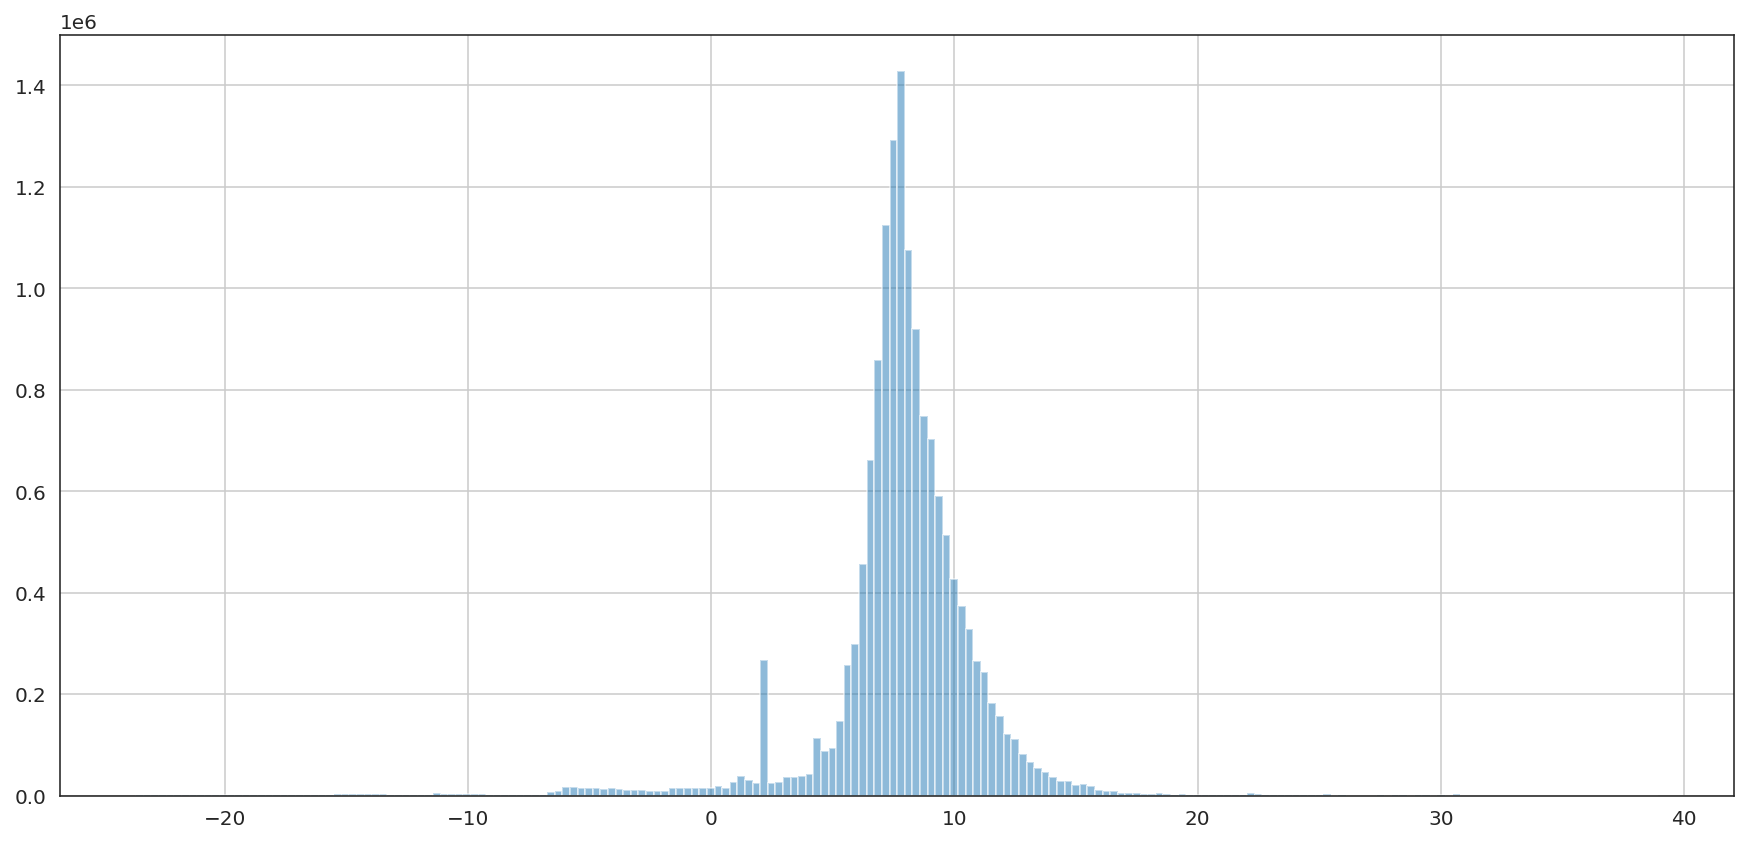

In [14]:
tfi.scanned_df.score.hist(bins = 200, alpha = 0.5)

Filtering finished: 15084603 -> 5382718


<AxesSubplot:>

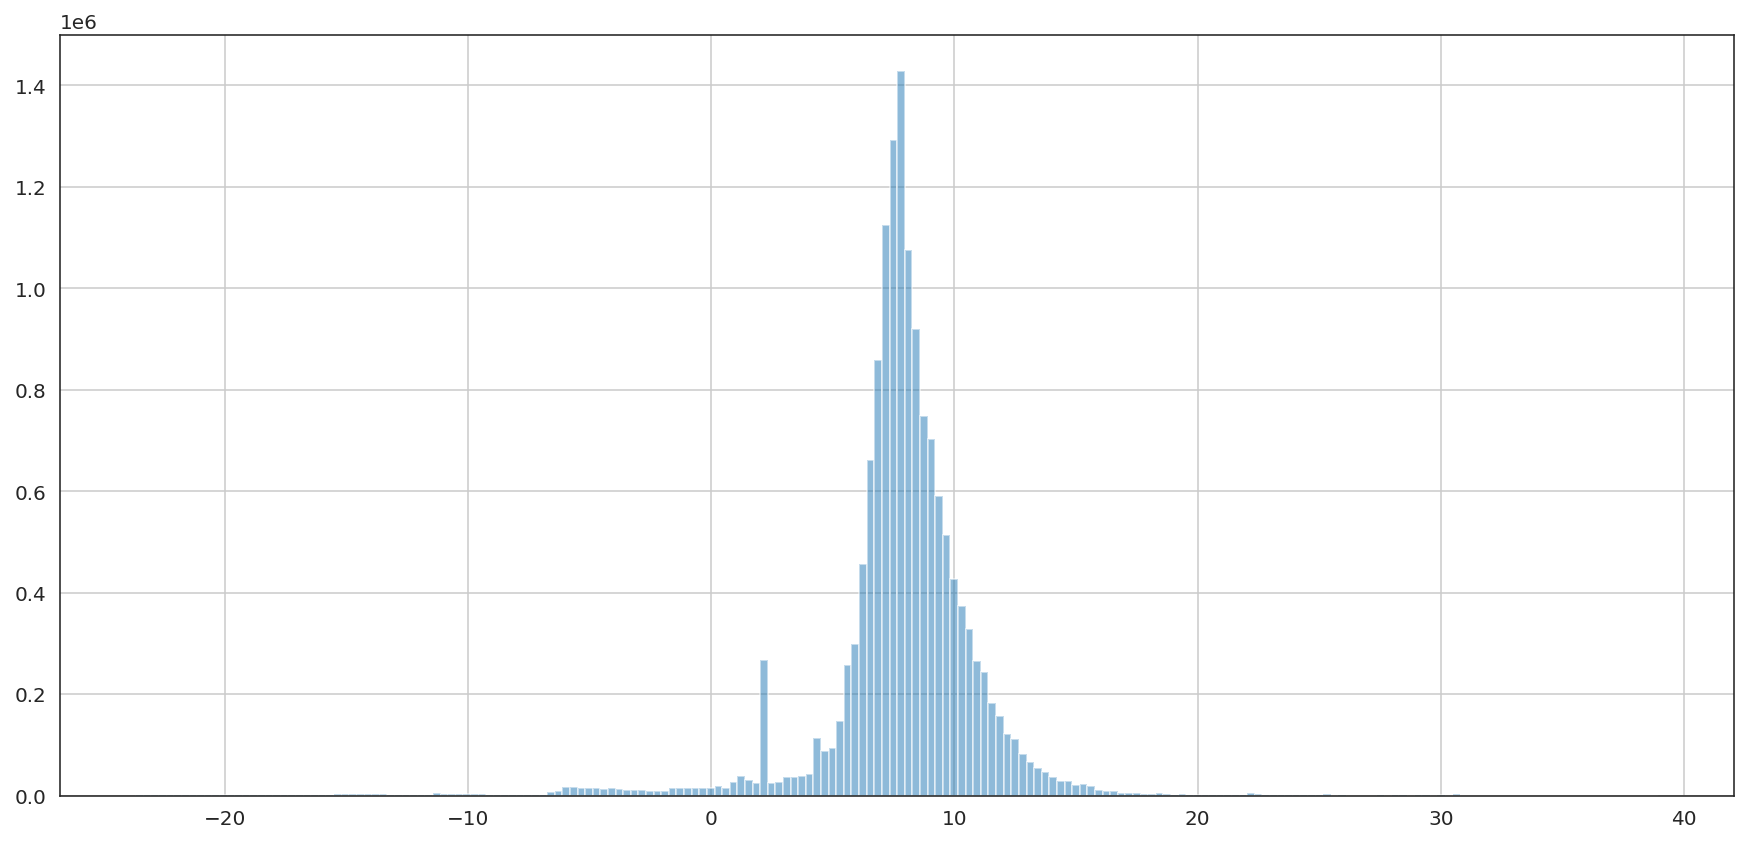

In [15]:
tfi.reset_filtering()
tfi.filter_motifs_by_score(threshold = 5)
tfi.scanned_df.score.hist(bins = 200, alpha = 0.5)

In [16]:
tfi.make_TFinfo_dataframe_and_dictionary(verbose = True)

1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/19677 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/18756 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

In [17]:
td = tfi.to_dictionary(dictionary_type="targetgene2TFs")

In [18]:
df = tfi.to_dataframe()
df.head()

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009195_100010375,DNMBP,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr10_100185305_100186689,ERLIN1,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
2,chr10_100228700_100230016,CHUK,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,chr10_100266970_100268170,CWF19L1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,chr10_100285935_100287169,BLOC1S2,1,0,1,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


### Save results

In [19]:
folder = "/home/jovyan/experiments/heart/8-celloracle/multiome/TFinfo_outputs"
os.makedirs(folder, exist_ok = True)

# save TFinfo as a dictionary
td = tfi.to_dictionary(dictionary_type = "targetgene2TFs")
save_as_pickled_object(td, os.path.join(folder, "TFinfo_targetgene2TFs.pickled"))

# save TFinfo as a dataframe
df = tfi.to_dataframe()
df.to_parquet(os.path.join(folder, "TFinfo_dataframe.parquet"))